In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.insert(1, '/Users/kunalchakraborty/Downloads/Appian/appianway/')

In [3]:
import econometrics

In [45]:
%reload_ext autoreload
%autoreload 2

In [117]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-117-1390d13c0cdd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Trade identified pairs

In [5]:
data_path = "/Users/kunalchakraborty/Downloads/Appian/data"
df = pd.read_csv(econometrics.get_data(data_path, "main_data.csv"))

In [8]:
performance_df = pd.read_csv(econometrics.get_data(data_path, "rahul_pair_performance.csv"))

In [7]:
## Trade individual pairs
rahul_pair = [('FB', 'GOOG'),
 ('KBH', 'TOL'),
 ('DHI', 'LEN'),
 ('CL', 'PG'),
 ('HAL', 'SLB'),
 ('CVX', 'XOM'),
 ('CSX', 'NSC'),
 ('ITT', 'PH'),
 ('TKR', 'URI'),
 ('RTX', 'WWD'),
 ('LRCX', 'MKSI'),
 ('ADI', 'MCHP'),
 ('QRVO', 'SWKS'),
 ('IP', 'WRK'),
 ('CE', 'EMN'),
 ('CDE', 'HL'),
 ('NUE', 'STLD'),
 ('CC', 'TROX'),
 ('IVV', 'SPY'),
 ('IWF', 'VUG'),
 ('RYN', 'WY')]

In [11]:
X = econometrics.normalize_price(econometrics.extract_time_series(df, "IVV","5. adjusted close", "2019-01-01","2021-07-31"))
Y = econometrics.normalize_price(econometrics.extract_time_series(df, "SPY","5. adjusted close", "2019-01-01","2021-07-31"))

indicator_series = performance_df[performance_df["pair"]=="IVV~SPY"][["end_date", "is_coint"]].set_index("end_date")

In [58]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
def plot_triple_curves(S1,S2, S3,xlabel, ylabel, zlabel, S1_label, S2_label, S3_label):
    fig, host = plt.subplots(figsize=(18,5)) # (width, height) in inches
    
    common_datelist = econometrics.get_common_dates(S2,S3)
    S1 = S1[S1.index.isin(common_datelist)]
    S2 = S2[S2.index.isin(common_datelist)]
    S3 = S3[S3.index.isin(common_datelist)]

    par1 = host.twinx()
    par2 = host.twinx()
    

    host.set_xlabel(xlabel)
    host.set_ylabel(S3_label)
    par1.set_ylabel(S1_label)
    par2.set_ylabel(S2_label)

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(S3.index, S3.values, color=color1, label=S3_label)
    p2, = par1.plot(S1.index, S1.values, color=color2, label=S1_label)
    p3, = par2.plot(S2.index, S2.values, color=color3, label=S2_label)

    lns = [p1, p2, p3]
    host.legend(handles=lns, loc='best')

In [101]:
X_norm = econometrics.normalize_price(econometrics.extract_time_series(df, "ADI","5. adjusted close", "2021-03-01","2021-07-31"))
Y_norm = econometrics.normalize_price(econometrics.extract_time_series(df, "MCHP","5. adjusted close", "2021-03-01","2021-07-31"))

X = econometrics.extract_time_series(df, "ADI","5. adjusted close", "2021-03-01","2021-07-31")
Y = econometrics.extract_time_series(df, "MCHP","5. adjusted close", "2021-03-01","2021-07-31")
indicator_series = performance_df[performance_df["pair"]=="ADI~MCHP"][["end_date", "is_coint"]].set_index("end_date")

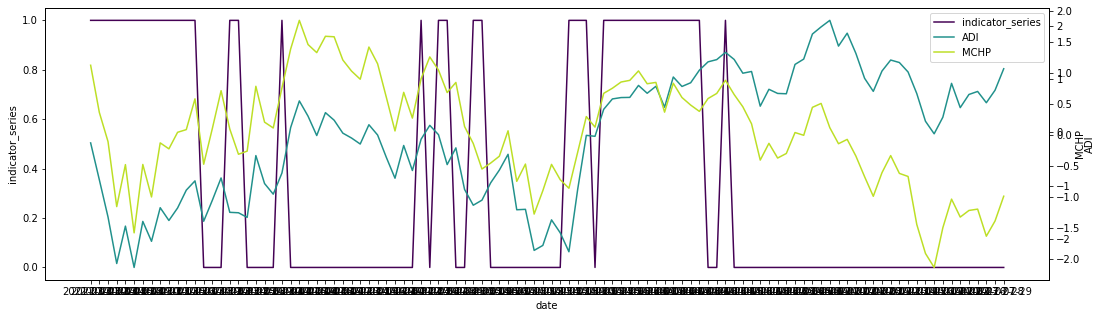

In [104]:
plot_triple_curves(X_norm,Y_norm,indicator_series, "date", "price1", "price2", "ADI", "MCHP","indicator_series")

### Experiment with pairs ADI and MCHP

Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


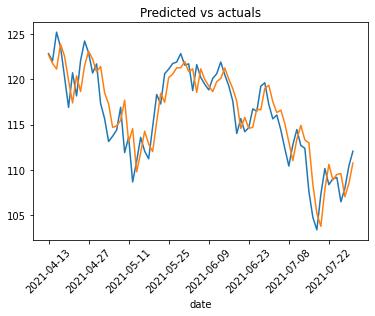

In [105]:
residual_series = econometrics.get_stationary_series(Y,X)
forecasted_deviations = econometrics.rolling_window_single_series_forecast(residual_series,30)
econometrics.plot_common_series(residual_series, forecasted_deviations, "Predicted vs actuals")

In [106]:
## Need series diff
## Compute deviations
differenced_series = econometrics.get_difference_series(residual_series, forecasted_deviations)

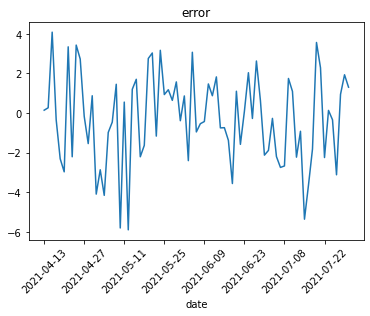

In [107]:
econometrics.plot_individual_series(differenced_series,title="error")

In [108]:
top_strategy, bottom_strategy, datelist = generate_mad_signals(differenced_series,3,0,window=30)

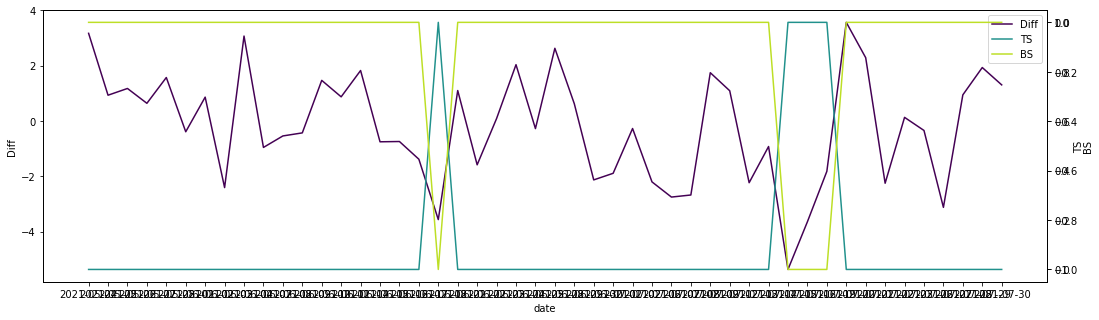

In [109]:
plot_triple_curves(pd.Series(top_strategy, index=datelist), 
                   pd.Series(bottom_strategy, index=datelist), differenced_series, "date", "indicator", "p diff", "TS", "BS","Diff")

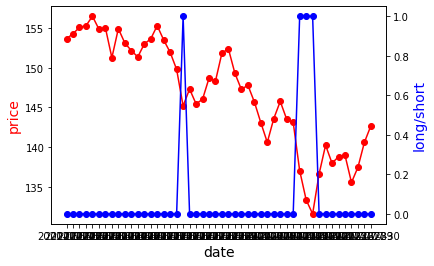

In [110]:
econometrics.plot_twin_axis(Y, pd.Series(top_strategy, index=datelist),"price","long/short")

In [111]:
lp, sp = compute_profits(Y, X, top_strategy, bottom_strategy, datelist, cointegrating_series = "Y")
print("Profit from long position = ", lp)
print("Profit from short position = ", sp)

print("Total profit from static hedges = ", lp + sp)

Profit from long position =  -5.983666965541354
Profit from short position =  11.612124963000014
Total profit from static hedges =  5.62845799745866


In [118]:
pd.concat([Y, pd.Series(top_strategy, index=datelist)],axis=1)

,5. adjusted close,0
2021-03-01,157.192977,NaN
2021-03-02,151.217456,NaN
2021-03-03,147.518798,NaN
2021-03-04,139.286301,NaN
2021-03-05,144.605608,NaN
2021-03-08,135.965462,NaN
2021-03-09,144.625493,NaN
2021-03-10,140.509244,NaN
2021-03-11,147.359716,NaN
2021-03-12,146.604076,NaN


In [66]:
def compute_profits(Y,X, top_strategy, bottom_strategy, datelist, cointegrating_series = "X", lag = 1):
    Y = Y[Y.index.isin(datelist)]
    X = X[X.index.isin(datelist)]
    top_profit = 0
    bottom_profit = 0
    top_strategy = pd.Series(top_strategy, index = datelist)
    bottom_strategy = pd.Series(bottom_strategy, index = datelist)


    switch = False
    sp_prev = 0
    for sp in range(1,len(Y)):
        if top_strategy[sp_prev] != top_strategy[sp]:
            if top_strategy[sp] != 0:
                if switch == False:
                    fp = sp
                    switch = True
                else:
                    top_profit+=(Y.iloc[sp] - Y.iloc[fp])*top_strategy[sp]
            else:
                switch = False

    top_profit+=Y.iloc[sp] - Y.iloc[fp]

    for sp in range(1,len(X)):
        if bottom_strategy[sp] != 0:
            if switch == False:
                fp = sp
                switch = True
            else:
                bottom_profit+=(X.iloc[sp] - X.iloc[fp])*bottom_strategy[sp]
        else:
            switch = False

    bottom_profit+=X.iloc[sp] - X.iloc[fp]

    if cointegrating_series == "X":
        bottom_profit = bottom_profit*abs(np.cov(Y,X)[0][1]/np.var(X))
    else:
        top_profit = top_profit*abs(np.cov(Y,X)[0][1]/np.var(Y))


    total_profit = top_profit + bottom_profit

    return top_profit, bottom_profit

In [120]:
Y

date
2021-03-01    157.192977
2021-03-02    151.217456
2021-03-03    147.518798
2021-03-04    139.286301
2021-03-05    144.605608
2021-03-08    135.965462
2021-03-09    144.625493
2021-03-10    140.509244
2021-03-11    147.359716
2021-03-12    146.604076
2021-03-15    148.701971
2021-03-16    149.040020
2021-03-17    152.937531
2021-03-18    144.655321
2021-03-19    149.199102
2021-03-22    153.971565
2021-03-23    149.119561
2021-03-24    145.918035
2021-03-25    146.315740
2021-03-26    154.528352
2021-03-29    149.984570
2021-03-30    149.248816
2021-03-31    154.329499
2021-04-01    159.251101
2021-04-05    162.880161
2021-04-06    159.817831
2021-04-07    158.793740
2021-04-08    160.861807
2021-04-09    160.802151
2021-04-12    157.859133
2021-04-13    156.457222
2021-04-14    155.423189
2021-04-15    159.499667
2021-04-16    157.381887
2021-04-19    153.146326
2021-04-20    148.870996
2021-04-21    153.762770
2021-04-22    150.501587
2021-04-23    155.482844
2021-04-26    158.24

In [35]:
top_strategy1 = pd.Series(top_strategy, index = datelist)

In [36]:
top_strategy1

2019-07-19    0
2021-03-01    0
2020-03-03   -1
2020-01-29    1
2021-04-22    0
             ..
2020-02-27    0
2020-03-17    1
2019-08-30    0
2020-11-16    0
2020-10-30    0
Length: 531, dtype: int64

In [51]:
def generate_mad_signals(tseries, entry_threshold = 2, exit_threshold = 1, window=60):
    mad = lambda x: np.abs(x - x.median()).median()
    mad_series = tseries.rolling(window).apply(mad)
    mad_series = mad_series.dropna()

    median_series = tseries.rolling(window).median()
    median_series = median_series.dropna()

    datelist = econometrics.get_common_dates(tseries, mad_series)
    tseries = tseries[tseries.index.isin(datelist)]
    mad_series = mad_series[mad_series.index.isin(datelist)]
    median_series = median_series[median_series.index.isin(datelist)]

    top_strategy = []
    value = 0
    trade_enter_up = False
    trade_enter_down = False
    for i in range(tseries.shape[0]):
        if tseries.iloc[i] > entry_threshold*mad_series.iloc[i] + median_series.iloc[i] and trade_enter_up == False:
            value = -1
            trade_enter_up = True
        elif tseries.iloc[i] < -entry_threshold*mad_series.iloc[i] + median_series.iloc[i] and trade_enter_down == False:
            value = 1
            trade_enter_down = True
        elif trade_enter_down == True and tseries.iloc[i] > -exit_threshold*mad_series.iloc[i] + median_series[i]:
            value = 0
            trade_enter_down = False
        elif trade_enter_up == True and tseries.iloc[i] < exit_threshold*mad_series.iloc[i] + median_series[i]:
            value = 0
            trade_enter_up = False

        top_strategy.append(value)
    bottom_strategy = [-1*x for x in top_strategy]

    return top_strategy, bottom_strategy, datelist

[0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 1,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,